In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
from keras.models import load_model
from PIL import Image
import numpy as np
import cv2

#the following are to do with this interactive notebook code

%matplotlib inline
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
import pylab # this allows you to control figure size
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # this controls figure size in the notebook


In [26]:
from google.colab.patches import cv2_imshow
from IPython.display import Image as IPImage
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

def js_to_image(js_reply):
    """
    Convert the JavaScript object into an OpenCV image and return it
    """
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

def take_photo(filename='photo.jpg', quality=1.5):
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getTracks().forEach(track => track.stop());
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    return js_to_image(data)

In [9]:
age_model_path = '/content/drive/My Drive/projek-kb/age/age_model_acc.h5'
age_model = load_model(age_model_path)

gender_model_path = 'drive/MyDrive/projek-kb/Gender/output_gender/UTKFace/gender_model.h5'
gender_model = load_model(gender_model_path)

emotion_model_path = 'drive/MyDrive/projek-kb/Emotion/emotion_model.h5'
emotion_model = load_model(emotion_model_path)

In [10]:
# export_dir='/content/drive/My Drive/projek-kb/age/age_model_acc.h5'
# age_model = load_model(export_dir)

# summarize model.
age_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 128)       7385

In [11]:
# export_dir = 'drive/MyDrive/projek-kb/Emotion/emotion_model.h5'
# emotion_model = load_model(export_dir)

In [12]:
# Labels on Age, Gender and Emotion to be predicted
max_age = 116
age_ranges = [str(i) for i in range(1, max_age + 1)]
gender_ranges = ['Male', 'Female']
emotion_ranges= ['positive','negative','neutral']

In [17]:
# Cell 4: Load the models
# Load the gender model
gender_model_path = '/content/drive/MyDrive/projek-kb/Gender/output_gender/UTKFace/gender_model.h5'
gender_model = load_model(gender_model_path)

In [18]:
# img_path = "./1.4_test_input/images/priyanka_chopra.jpg"
# img_path = "./1.4_test_input/images/kartik_aryan.jpg"
img_path = "/content/drive/MyDrive/projek-kb/aurum.jpg"

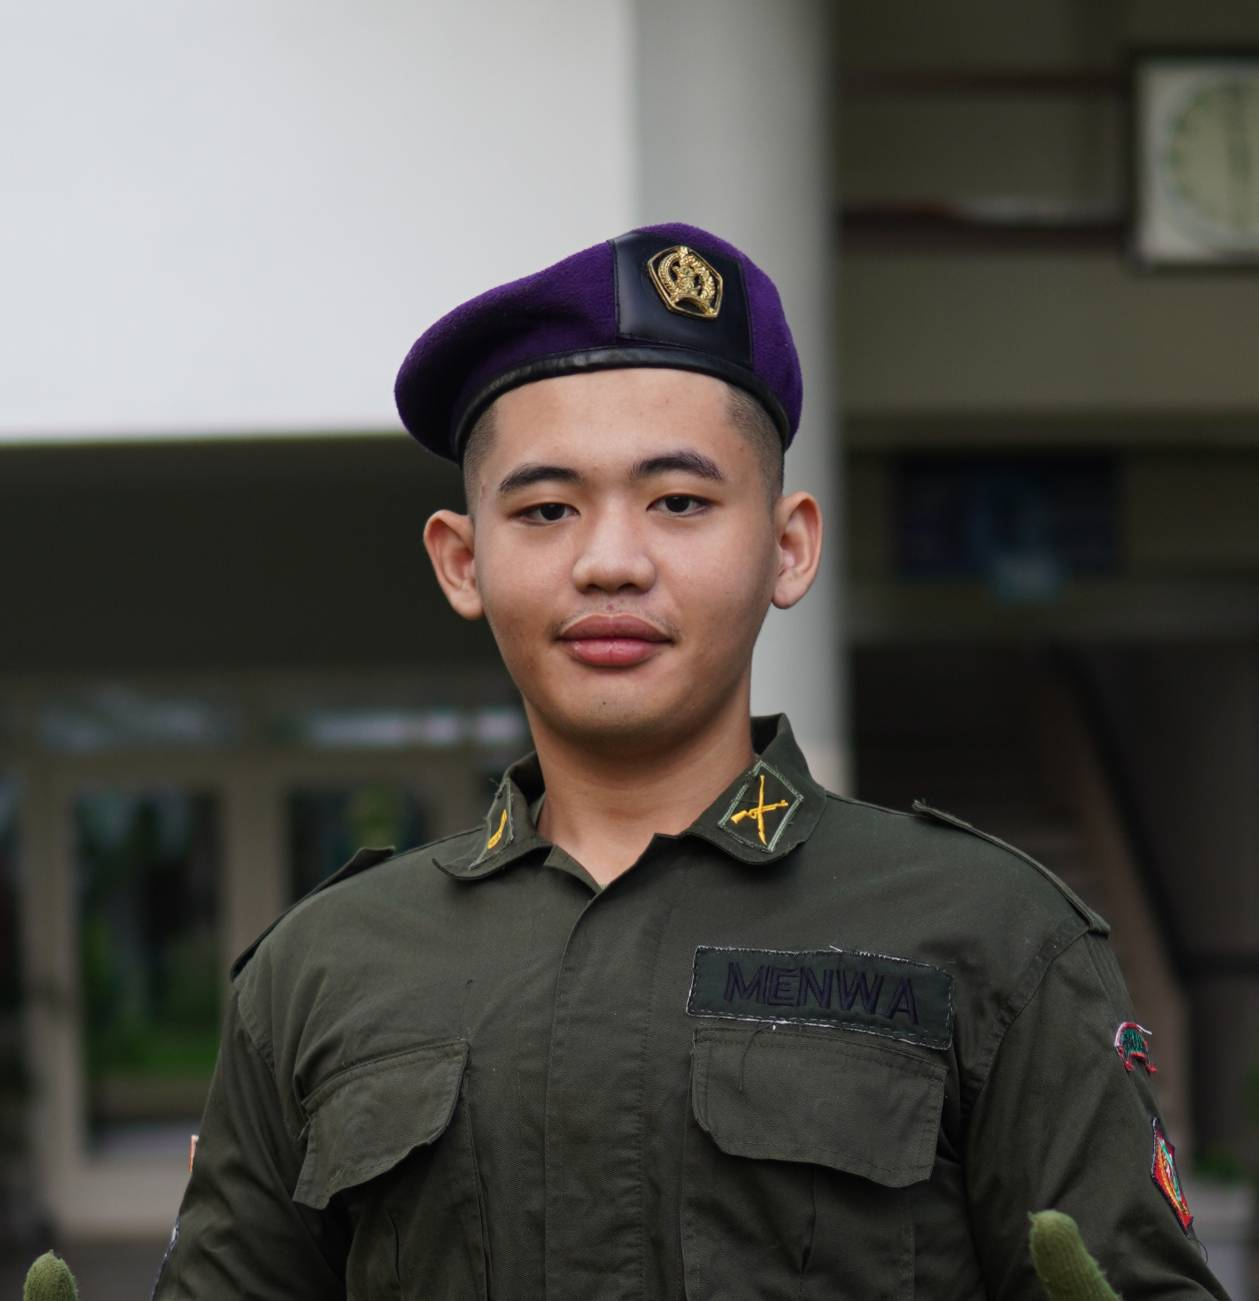

In [19]:
from IPython.display import Image
pil_img = Image(filename=img_path)
display(pil_img)

In [20]:
def preprocess_image(image, target_size):
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    image = np.expand_dims(image, axis=-1)  # Add channel dimension if needed
    return image

1/1 [==============================] - 0s 32ms/step


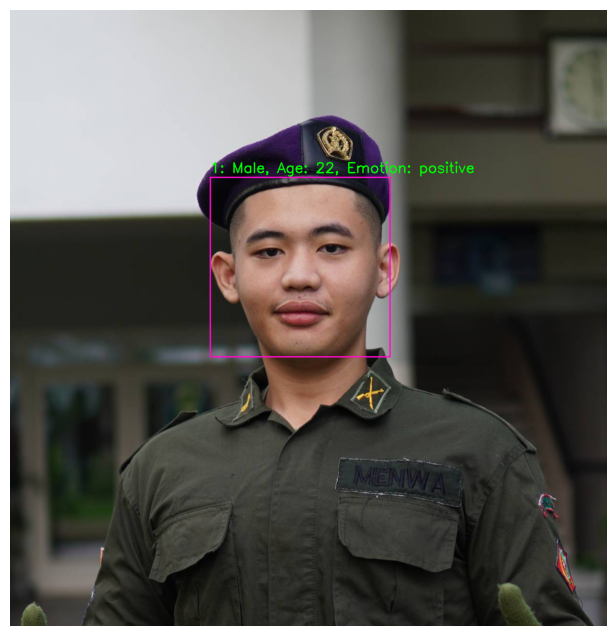

In [25]:
# Foto tanpa Kamera
test_image = cv2.imread(img_path)
gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/projek-kb/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=9)

i = 0

for (x, y, w, h) in faces:
    i += 1
    cv2.rectangle(test_image, (x, y), (x + w, y + h), (203, 12, 255), 2)
    img_gray = gray[y:y + h, x:x + w]

    # Resize and preprocess the face image for gender prediction
    gender_image = cv2.resize(img_gray, (100, 100), interpolation=cv2.INTER_AREA)
    gender_image = gender_image / 255.0  # Normalize
    gender_input = gender_image.reshape(1, 100, 100, 1)

    # Predict the gender
    gender_pred = gender_model.predict(gender_input)
    gender_label = gender_ranges[np.argmax(gender_pred)]

    # Resize and preprocess the face image for age prediction
    age_image = cv2.resize(img_gray, (128, 128), interpolation=cv2.INTER_AREA)
    age_image = age_image / 255.0  # Normalize
    age_input = age_image.reshape(1, 128, 128, 1)


    emotion_img = cv2.resize(img_gray, (48, 48), interpolation = cv2.INTER_AREA)
    emotion_image_array = np.array(emotion_img)
    emotion_input = np.expand_dims(emotion_image_array, axis=0)
    output_emotion= emotion_ranges[np.argmax(emotion_model.predict(emotion_input))]

    # Predict the age
    pred_age = age_model.predict(age_input)
    pred_age = round(pred_age[0][0])

    # Output string for gender and age
    output_str = f"{i}: {gender_label}, Age: {pred_age}, Emotion: {output_emotion}"

    # Display the predicted gender and age on the image
    col = (0, 255, 0)
    cv2.putText(test_image, output_str, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, col, 2)

# Display the image with bounding boxes and predicted gender and age
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 30ms/step


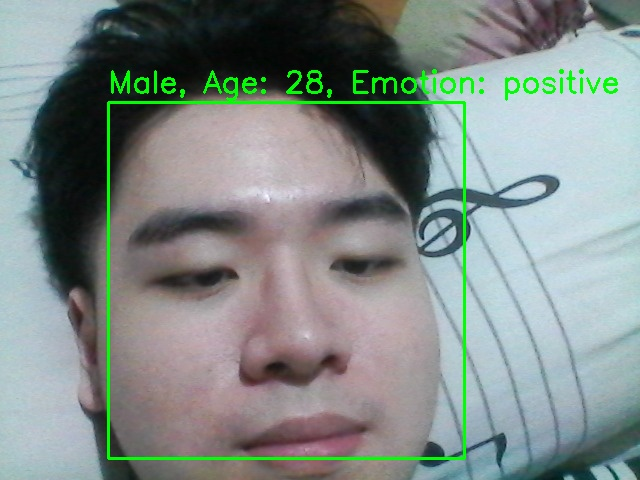

<IPython.core.display.Javascript object>

AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
# Load the face detection model
face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/projek-kb/haarcascade_frontalface_default.xml')

while True:
    # Take photo
    img = take_photo()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=9)

    for (x, y, w, h) in faces:

        face = gray[y:y+h, x:x+w]

        # Resize and preprocess for gender prediction
        gender_image = cv2.resize(face, (100, 100),interpolation=cv2.INTER_AREA)
        gender_image = gender_image / 255.0  # Normalize
        gender_input = gender_image.reshape(1, 100, 100, 1)
        gender_pred = gender_model.predict(gender_input)
        gender_label = gender_ranges[np.argmax(gender_pred)]

        # Resize and preprocess for age prediction
        age_image = cv2.resize(face, (128, 128),interpolation=cv2.INTER_AREA)
        age_image = age_image / 255.0  # Normalize
        age_input = age_image.reshape(1, 128, 128, 1)
        pred_age = age_model.predict(age_input)
        pred_age = round(pred_age[0][0])

        # Resize and preprocess for emotion prediction
        emotion_img = cv2.resize(face, (48, 48), interpolation=cv2.INTER_AREA)
        emotion_image_array = np.array(emotion_img)
        emotion_input = np.expand_dims(emotion_image_array, axis=0)
        output_emotion = emotion_ranges[np.argmax(emotion_model.predict(emotion_input))]

        # Display predictions on the image
        col = (0, 255, 0)
        label = f"{gender_label}, Age: {pred_age}, Emotion: {output_emotion}"
        cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, col, 2)
        cv2.rectangle(img, (x, y), (x + w, y + h), col, 2)

    # Display the image with bounding boxes and predictions
    display(IPImage(data=cv2.imencode('.jpg', img)[1].tobytes()))

    # Add a delay to capture the next frame
    time.sleep(1)